In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.inspection import permutation_importance
from eli5.sklearn import PermutationImportance
import eli5
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

c:\users\aian\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\users\aian\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


### Treinando modelo do MSR

In [48]:
msr_data = pd.read_csv('msr_results/tokenslockeywordskeywordcount.csv', encoding = 'ANSI')
y_msr = msr_data['class']
msr_data.columns

Index(['token', 'loc', 'abstract_keyword', 'assert_keyword', 'boolean_keyword',
       'break_keyword', 'byte_keyword', 'case_keyword', 'catch_keyword',
       'char_keyword', 'class_keyword', 'continue_keyword', 'default_keyword',
       'do_keyword', 'double_keyword', 'else_keyword', 'enum_keyword',
       'exports_keyword', 'extends_keyword', 'final_keyword',
       'finally_keyword', 'float_keyword', 'for_keyword', 'if_keyword',
       'implements_keyword', 'import_keyword', 'instanceof_keyword',
       'int_keyword', 'interface_keyword', 'long_keyword', 'modules_keyword',
       'native_keyword', 'new_keyword', 'package_keyword', 'private_keyword',
       'protected_keyword', 'public_keyword', 'requires_keyword',
       'return_keyword', 'short_keyword', 'static_keyword', 'strictfp_keyword',
       'super_keyword', 'switch_keyword', 'synchronized_keyword',
       'this_keyword', 'throw_keyword', 'throws_keyword', 'transient_keyword',
       'try_keyword', 'void_keyword', 'volatile

In [49]:
vectorizer = CountVectorizer(max_features=1000)
bag_of_words = vectorizer.fit_transform(msr_data['token'])
sparse_matrix = pd.DataFrame(bag_of_words.toarray(), columns = vectorizer.get_feature_names())

#dropped_data = msr_data.drop(labels = ['@@class@@', 'tokens'], axis = 'columns')
pre_processed_data = [sparse_matrix, msr_data['loc']]
X_msr = pd.concat(pre_processed_data, axis=1)

Xtrain, Xtest, ytrain, ytest = train_test_split(X_msr, y_msr, train_size=0.8, random_state=33, shuffle=True)

msr_model = RandomForestClassifier(n_estimators=100, random_state=33, oob_score=True)
msr_model.fit(Xtrain, ytrain)
preds = msr_model.predict(Xtest)

print("f1: {}, oob: {}".format(f1_score(ytest, preds, pos_label='flaky'), msr_model.oob_score_))

f1: 0.9461966604823748, oob: 0.9456085599643335


In [54]:
X_msr.columns[:30]

Index(['00', '0000000', '00z', '01', '01t01', '02', '03', '05', '06', '07',
       '08', '09', '0o', '0oeaaaa', '10', '100', '103', '11', '113', '12',
       '123', '1234', '127', '13', '14', '15', '16', '20', '200', '2009'],
      dtype='object')

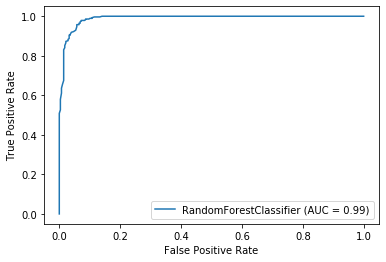

In [36]:
roc = plot_roc_curve(msr_model, Xtest, ytest)

In [37]:
importances = pd.DataFrame(msr_model.feature_importances_, index = Xtrain.columns,
                            columns=['importance']).sort_values('importance', ascending=False)

importances[:10]

,importance
job,0.033778
action,0.028226
services,0.026677
id,0.024047
oozie,0.023861
table,0.021996
cluster,0.019371
loc,0.017368
get,0.015965
workflow,0.015417


Text(0, 0.5, 'Token')

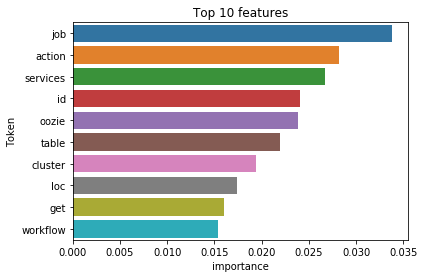

In [38]:
sns.barplot(y=importances.index[:10], x=importances['importance'][:10])
plt.title('Top 10 features')
plt.ylabel('Token')

### Treinando modelo com novos dados

In [51]:
dataset = pd.read_csv('new_data/dataset.csv')
y = dataset['class']
dataset.columns

Index(['token', 'loc', 'class'], dtype='object')

In [52]:
count_vectorizer = CountVectorizer(max_features=1000)
bag_of_words = count_vectorizer.fit_transform(dataset['token'])
features = count_vectorizer.get_feature_names()
string_to_word = pd.DataFrame(bag_of_words.toarray(), columns = features)

frames = [string_to_word, dataset['loc']]
X = pd.concat(frames, axis=1)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, random_state=33, shuffle=True)

model = RandomForestClassifier(n_estimators=100, random_state=33, oob_score=True)
model.fit(Xtrain, ytrain)
preds = model.predict(Xtest)

print("f1: {}, oob: {}".format(f1_score(ytest, preds, pos_label='flaky'), model.oob_score_))

f1: 0.9120521172638437, oob: 0.901541095890411


In [53]:
X.columns[:30]

Index(['10', '100', '123456', '127', '200', '255', '30', '60', '8080', 'abc',
       'abcd', 'abcde', 'accept', 'acceptframe', 'accepthandshakeasserver',
       'actiondb', 'activiti', 'actual', 'add', 'addargument', 'addarguments',
       'addchild', 'addcluster', 'addcolumn', 'addcontent', 'adddeletion',
       'addenvironment', 'addfamily', 'addfirst', 'addheader'],
      dtype='object')

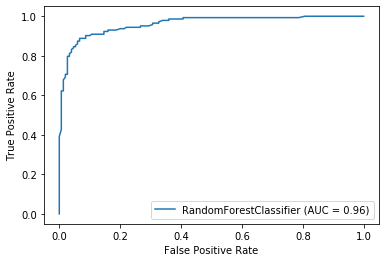

In [41]:
roc = plot_roc_curve(model, Xtest, ytest)

In [42]:
importances = pd.DataFrame(model.feature_importances_, index = Xtrain.columns,
                            columns=['importance']).sort_values('importance',ascending=False)

importances[:10]

,importance
loc,0.058765
mtfs,0.017945
getendpointbean,0.014323
assertsame,0.013599
assertequals,0.012423
testscan,0.009228
connection,0.009168
conf,0.009123
run,0.008402
controller,0.008340


Text(0, 0.5, 'Token')

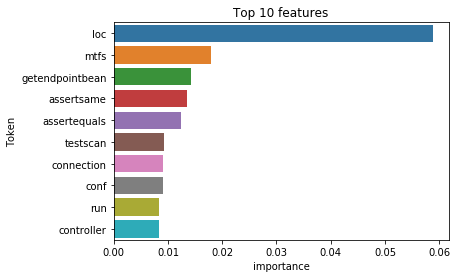

In [43]:
sns.barplot(y=importances.index[:10], x=importances['importance'][:10])
plt.title('Top 10 features')
plt.ylabel('Token')

In [24]:
perm = PermutationImportance(model, random_state=1).fit(Xtest, ytest)
eli5.show_weights(perm, feature_names = Xtest.columns.tolist())

Weight,Feature
0.0362 ± 0.0055,loc
0.0150 ± 0.0153,controller
0.0137 ± 0.0156,assertequals
0.0116 ± 0.0119,conf
0.0102 ± 0.0075,mtfs
0.0068 ± 0.0000,standard1
0.0068 ± 0.0000,insert
0.0061 ± 0.0027,name
0.0055 ± 0.0093,getendpointbean
0.0048 ± 0.0070,assert


### Avaliando modelo do MSR nos novos dados

In [44]:
new_preds = msr_model.predict(X)
new_preds = np.where(new_preds == 'non_flaky ', 'non_flaky', new_preds) 
f1_score(y, new_preds, pos_label='flaky')

0.14285714285714285

### Testando vetorizacao por TfIdf 

In [45]:
tfidf_model = TfidfVectorizer(max_features=500, use_idf=False)
bag_of_words = tfidf_model.fit_transform(dataset['token'])
sparse_matrix = pd.DataFrame(bag_of_words.toarray(), columns = tfidf_model.get_feature_names())
dataset_frame = [sparse_matrix, dataset['loc']]
X_new = pd.concat(frames, axis=1)

Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, y, train_size=0.8, 
                                                random_state=33, shuffle=True)

new_rf_model = RandomForestClassifier(n_estimators=100, random_state=33)
new_rf_model.fit(Xtrain, ytrain)
preds = new_rf_model.predict(Xtest)
f1_score(ytest, preds, pos_label='flaky')

0.9120521172638437

In [47]:
importances = pd.DataFrame(new_rf_model.feature_importances_, index = Xtrain.columns,
                            columns=['importance']).sort_values('importance',ascending=False)

importances[:10]

,importance
loc,0.058765
mtfs,0.017945
getendpointbean,0.014323
assertsame,0.013599
assertequals,0.012423
testscan,0.009228
connection,0.009168
conf,0.009123
run,0.008402
controller,0.008340
